In [1]:
import numpy as np
import scipy as sp
from scipy import linalg as sp_linalg
import matplotlib.pyplot as plt
%matplotlib inline

V = 100
rng = np.random.RandomState(0)

power_law_seed = rng.power(a=1.0, size=V)
P_ij = np.triu(rng.lognormal(mean=1, sigma=1, size=[V, V]), k=1)
P_ij *= power_law_seed
P_ij += P_ij.T #P_ij == P_ji
P_ij /= P_ij.sum()

p_i = P_ij.sum(axis=1)
P_i = np.diag(p_i)
P_i_inv = np.diag(1.0 / p_i)
similarities = P_i_inv.dot(P_ij).dot(P_i_inv)

pmis = np.log(similarities)
pmis[pmis == -np.inf] = 0

assert np.allclose(similarities, similarities.T)
assert np.allclose(similarities.dot(P_i).sum(axis=1), 1)
assert np.allclose(P_ij, P_ij.T)
assert np.allclose(pmis, pmis.T)
assert np.allclose(P_i.sum(), 1)
assert np.allclose(P_ij.sum(), 1)

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


In [2]:
p_i.min(), p_i.max()

(0.00012232142177970225, 0.025151188047223612)

In [3]:
P_ij[P_ij != 0].min()

2.3510023686686514e-08

In [4]:
similarities[similarities != 0].min(), similarities.max()

(0.0022734043329924124, 20.83410688459186)

In [5]:
def pmi_correction(P_ij, p_i, n):
    first_correction = 1 / P_ij
    np.fill_diagonal(first_correction, 0)
    second_correction = np.repeat(p_i.reshape(-1, 1), P_ij.shape[0], axis=1)
    return (second_correction + second_correction.T - first_correction - 1)/(2*n)

def relative_frob_norm(estimate, original):
    error_norm = np.linalg.norm(estimate - original)
    original_norm = np.linalg.norm(original)
    return error_norm / original_norm

def estimate_errors(P_ij, num_samples, sample_sizes, error_fun, seed=0, eps=1e-15):
    rng = np.random.RandomState(seed)
    errors = np.zeros([len(sample_sizes), 7])
    
    for k in range(num_samples):
        for e, n in enumerate(sample_sizes):
            emp_ij = rng.multinomial(n, P_ij.flatten()).reshape([V, V])
            emp_ij = emp_ij / emp_ij.sum()
            P_ij_err = error_fun(emp_ij, P_ij)

            emp_i = emp_ij.sum(axis=1)
            non_zeros = emp_i != 0
            emp_ij = emp_ij[non_zeros][:, non_zeros]
            emp_i = emp_i[non_zeros]
            P_i_err = error_fun(emp_i, p_i[non_zeros])
            
            emp_i_inv = np.diag(1.0 / emp_i)
            emp_sim = emp_i_inv.dot(emp_ij).dot(emp_i_inv)
            sim_err = error_fun(emp_sim, similarities[non_zeros][:, non_zeros])
            
            emp_eps_pmi = np.log(emp_sim + eps)
            np.fill_diagonal(emp_eps_pmi, 0)
            eps_pmi_error = error_fun(emp_eps_pmi, pmis[non_zeros][:, non_zeros])
            
            emp_ppmi = emp_eps_pmi.copy()
            emp_ppmi[emp_ppmi < 0] = 0
            ppmi_error = error_fun(emp_ppmi, pmis[non_zeros][:, non_zeros])
            
            positive_pmis = (pmis[non_zeros][:, non_zeros]).copy()
            positive_pmis[positive_pmis < 0] = 0
            ppmi_error_on_positive = error_fun(emp_ppmi, positive_pmis)
            
            corrected_est_pmi = emp_eps_pmi.copy()
            corrected_est_pmi += pmi_correction(P_ij[non_zeros][:, non_zeros], p_i[non_zeros], n)
#             print(corrected_est_pmi)
            corrected_pmi_error = error_fun(corrected_est_pmi, pmis[non_zeros][:, non_zeros])
            
            errors[e, 0] += P_ij_err
            errors[e, 1] += P_i_err
            errors[e, 2] += sim_err
            errors[e, 3] += eps_pmi_error
            errors[e, 4] += ppmi_error
            errors[e, 5] += ppmi_error_on_positive
            errors[e, 6] += corrected_pmi_error
            
    errors /= num_samples
    return errors.T

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


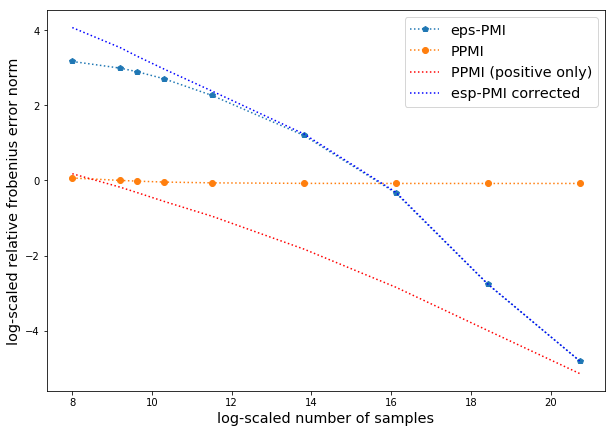

In [7]:
num_samples = 100
sample_sizes = P_ij.shape[0]**2 * np.array([0.3, 1, 1.5, 3, 10, 100, 1000, 10000, 100000])
errors = estimate_errors(P_ij, num_samples, sample_sizes, relative_frob_norm, eps=1e-15)

x = np.log(sample_sizes)
fig, ax = plt.subplots(figsize=(10,7))
# ax.plot(x, np.log(errors[0]), 'r--', label="P(i,j)")
# ax.plot(x, np.log(errors[1]), 'bs', label="P(i)")
# ax.plot(x, np.log(errors[2]), 'g^', label="exp(PMI)")
ax.plot(x, np.log(errors[3]), 'p:', label="eps-PMI")
ax.plot(x, np.log(errors[4]), 'o:', label="PPMI")
ax.plot(x, np.log(errors[5]), 'r:', label="PPMI (positive only)")
ax.plot(x, np.log(errors[6]), 'b:', label="esp-PMI corrected")

plt.legend(loc='upper right', fontsize="x-large")
plt.xlabel('log-scaled number of samples', fontsize="x-large")
plt.ylabel('log-scaled relative frobenius error norm', fontsize="x-large")
plt.show()

In [87]:
num_bins = 5
_, pop_bin_edges = np.histogram(p_i, bins=num_bins)

bin_indices = []
for i in range(num_bins):
    bin_indices.append(np.argwhere(
        np.logical_and(pop_bin_edges[i] <= p_i, p_i < pop_bin_edges[i+1])
    ).flatten())

num_error_samples = 100
res = np.zeros([num_bins, num_bins])

for seed in range(num_error_samples):
    rng = np.random.RandomState(seed)
    n = 100
    num_vars = V**2
    emp_ij = rng.multinomial(n * num_vars, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()
    
    for i in range(num_bins):
        for j in range(num_bins):
            res[-i-1,j] += mean_squared_error(
                emp_ij[bin_indices[i]][:, bin_indices[j]], 
                P_ij[bin_indices[i]][:, bin_indices[j]])
            
res /= num_error_samples

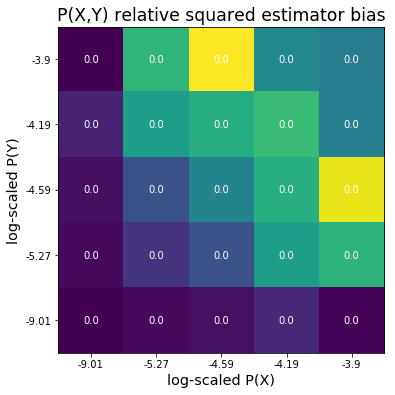

In [88]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(res)
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(np.log(pop_bin_edges[:-1]).round(2))
ax.set_yticklabels(np.log(pop_bin_edges[:-1][::-1]).round(2))
for i in range(num_bins):
    for j in range(num_bins):
        text = ax.text(j, i, res[i,j].round(2),
                       ha="center", va="center", color="w")
plt.xlabel('log-scaled P(X)', fontsize="x-large")
plt.ylabel('log-scaled P(Y)', fontsize="x-large")
plt.title('P(X,Y) relative squared estimator bias', fontsize="xx-large")
plt.show()

In [25]:
num_bins = 5
_, pop_bin_edges = np.histogram(p_i, bins=num_bins)

bin_indices = []
for i in range(num_bins):
    bin_indices.append(np.argwhere(
        np.logical_and(pop_bin_edges[i] <= p_i, p_i < pop_bin_edges[i+1])
    ).flatten())

num_error_samples = 100
res = np.zeros([num_bins, num_bins])

for seed in range(num_error_samples):
    rng = np.random.RandomState(seed)
    n = 100
    num_vars = V**2
    emp_ij = rng.multinomial(n * num_vars, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()
    emp_i = emp_ij.sum(axis=1)    
    emp_i_inv = np.diag(1.0 / emp_i)
    emp_sim = emp_i_inv.dot(emp_ij).dot(emp_i_inv)
    
    for i in range(num_bins):
        for j in range(num_bins):
            res[-i-1,j] += mean_relative_squared_error(
                emp_sim[bin_indices[i]][:, bin_indices[j]], 
                similarities[bin_indices[i]][:, bin_indices[j]])
            
res /= num_error_samples

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


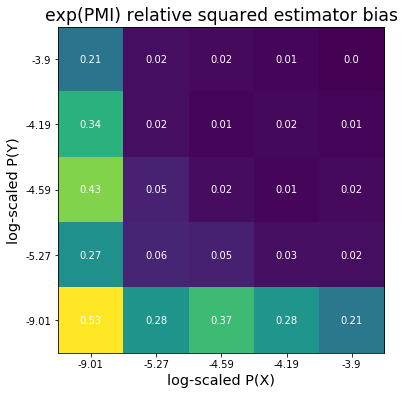

In [26]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(res)
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(np.log(pop_bin_edges[:-1]).round(2))
ax.set_yticklabels(np.log(pop_bin_edges[:-1][::-1]).round(2))
for i in range(num_bins):
    for j in range(num_bins):
        text = ax.text(j, i, res[i,j].round(2),
                       ha="center", va="center", color="w")
plt.xlabel('log-scaled P(X)', fontsize="x-large")
plt.ylabel('log-scaled P(Y)', fontsize="x-large")
plt.title('exp(PMI) relative squared estimator bias', fontsize="xx-large")
plt.show()

In [129]:
num_bins = 5
sizes, pop_bin_edges = np.histogram(p_i, bins=num_bins)

bin_indices = []
for i in range(num_bins):
    bin_indices.append(np.argwhere(
        np.logical_and(pop_bin_edges[i] <= p_i, p_i < pop_bin_edges[i+1])
    ).flatten())

num_error_samples = 100
res = np.zeros([num_bins, num_bins])

for seed in range(num_error_samples):
    rng = np.random.RandomState(seed)
    n = 0.1
    num_vars = V**2
    emp_ij = rng.multinomial(n * num_vars, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()
    emp_i = emp_ij.sum(axis=1)    
    emp_i_inv = np.diag(1.0 / emp_i)
    emp_sim = emp_i_inv.dot(emp_ij).dot(emp_i_inv)
    emp_pmi = np.log(emp_sim)
    emp_pmi[emp_pmi == -np.inf] = 0
    
    for i in range(num_bins):
        for j in range(num_bins):
#             res[-i-1,j] += similarities[bin_indices[i]][:, bin_indices[j]].mean()
            res[-i-1,j] += mean_squared_error(
                emp_pmi[bin_indices[i]][:, bin_indices[j]], 
                pmis[bin_indices[i]][:, bin_indices[j]])
            
res /= num_error_samples

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


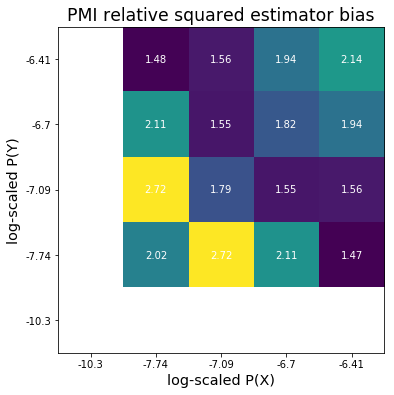

In [130]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(res)
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(np.log(pop_bin_edges[:-1]).round(2))
ax.set_yticklabels(np.log(pop_bin_edges[:-1][::-1]).round(2))
for i in range(num_bins):
    for j in range(num_bins):
        text = ax.text(j, i, res[i,j].round(2),
                       ha="center", va="center", color="w")
plt.xlabel('log-scaled P(X)', fontsize="x-large")
plt.ylabel('log-scaled P(Y)', fontsize="x-large")
plt.title('PMI relative squared estimator bias', fontsize="xx-large")
plt.show()

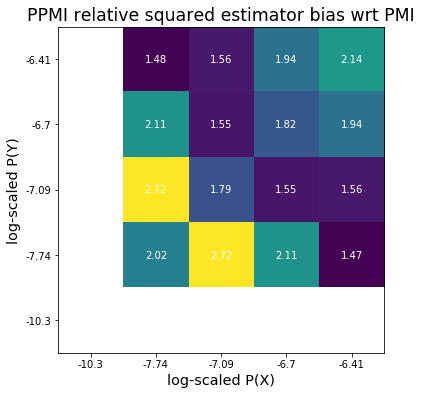

In [132]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(res)
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(np.log(pop_bin_edges[:-1]).round(2))
ax.set_yticklabels(np.log(pop_bin_edges[:-1][::-1]).round(2))
for i in range(num_bins):
    for j in range(num_bins):
        text = ax.text(j, i, res[i,j].round(2),
                       ha="center", va="center", color="w")
plt.xlabel('log-scaled P(X)', fontsize="x-large")
plt.ylabel('log-scaled P(Y)', fontsize="x-large")
plt.title('PPMI relative squared estimator bias wrt PMI', fontsize="xx-large")
plt.show()

In [131]:
num_bins = 5
_, pop_bin_edges = np.histogram(p_i, bins=num_bins)

bin_indices = []
for i in range(num_bins):
    bin_indices.append(np.argwhere(
        np.logical_and(pop_bin_edges[i] <= p_i, p_i < pop_bin_edges[i+1])
    ).flatten())

num_error_samples = 100
res = np.zeros([num_bins, num_bins])

for seed in range(num_error_samples):
    rng = np.random.RandomState(seed)
    n = 0.1
    num_vars = V**2
    emp_ij = rng.multinomial(n * num_vars, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()
    emp_i = emp_ij.sum(axis=1)    
    emp_i_inv = np.diag(1.0 / emp_i)
    emp_sim = emp_i_inv.dot(emp_ij).dot(emp_i_inv)
    emp_pmi = np.log(emp_sim)
    emp_pmi[emp_pmi == -np.inf] = 0
    emp_pmi[emp_pmi < 0] = 0 ### PPMI
    
    for i in range(num_bins):
        for j in range(num_bins):
            res[-i-1,j] += mean_squared_error(
                emp_pmi[bin_indices[i]][:, bin_indices[j]], 
                pmis[bin_indices[i]][:, bin_indices[j]])
            
res /= num_error_samples

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


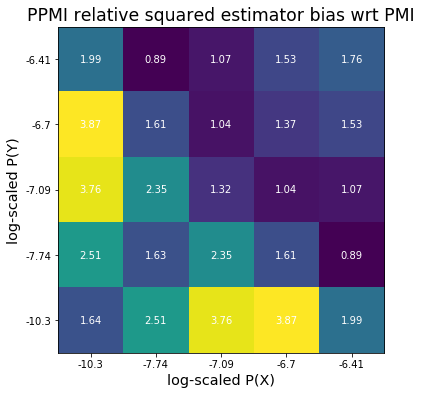

In [123]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(res)
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(np.log(pop_bin_edges[:-1]).round(2))
ax.set_yticklabels(np.log(pop_bin_edges[:-1][::-1]).round(2))
for i in range(num_bins):
    for j in range(num_bins):
        text = ax.text(j, i, res[i,j].round(2),
                       ha="center", va="center", color="w")
plt.xlabel('log-scaled P(X)', fontsize="x-large")
plt.ylabel('log-scaled P(Y)', fontsize="x-large")
plt.title('PPMI relative squared estimator bias wrt PMI', fontsize="xx-large")
plt.show()

In [51]:
num_bins = 5
_, pop_bin_edges = np.histogram(p_i, bins=num_bins)

bin_indices = []
for i in range(num_bins):
    bin_indices.append(np.argwhere(
        np.logical_and(pop_bin_edges[i] <= p_i, p_i < pop_bin_edges[i+1])
    ).flatten())

num_error_samples = 100
res = np.zeros([num_bins, num_bins])

for seed in range(num_error_samples):
    rng = np.random.RandomState(seed)
    n = 100
    num_vars = V**2
    emp_ij = rng.multinomial(n * num_vars, P_ij.flatten()).reshape([V, V])
    emp_ij = emp_ij / emp_ij.sum()
    emp_i = emp_ij.sum(axis=1)    
    emp_i_inv = np.diag(1.0 / emp_i)
    emp_sim = emp_i_inv.dot(emp_ij).dot(emp_i_inv)
    emp_pmi = np.log(emp_sim)
    emp_pmi[emp_pmi == -np.inf] = 0
    emp_pmi[emp_pmi < 0] = 0 ### PPMI
    
    for i in range(num_bins):
        for j in range(num_bins):
            res[-i-1,j] += median_relative_squared_error(
                emp_pmi[bin_indices[i]][:, bin_indices[j]], 
                pmis[bin_indices[i]][:, bin_indices[j]])
            
res /= num_error_samples

/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/i.lobov/research/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


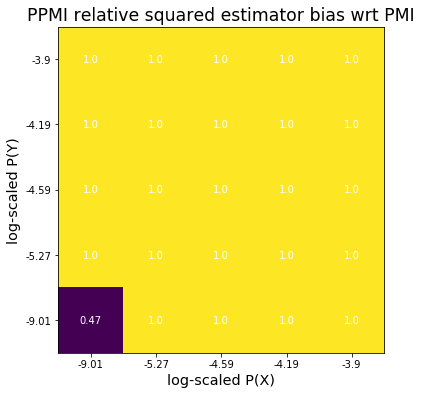

In [52]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(res)
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(np.log(pop_bin_edges[:-1]).round(2))
ax.set_yticklabels(np.log(pop_bin_edges[:-1][::-1]).round(2))
for i in range(num_bins):
    for j in range(num_bins):
        text = ax.text(j, i, res[i,j].round(2),
                       ha="center", va="center", color="w")
plt.xlabel('log-scaled P(X)', fontsize="x-large")
plt.ylabel('log-scaled P(Y)', fontsize="x-large")
plt.title('PPMI relative squared estimator bias wrt PMI', fontsize="xx-large")
plt.show()